# General notes about the data set

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook')

## Potentially unuseful columns
There are some general metadata columns about the images that are not interesting for display, these include the image width, height, the pixel spacing, and the image identifier ("Image Index").

In [2]:
data = pd.read_csv("dataset/Data_Entry_2017.csv")
data.drop(['Image Index', 'Image Width', 'Image Height', 'Spacing X', 'Spacing Y'], axis=1).head(20)

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
0,Cardiomegaly,0,1,58,M,PA
1,Cardiomegaly|Emphysema,1,1,58,M,PA
2,Cardiomegaly|Effusion,2,1,58,M,PA
3,No Finding,0,2,81,M,PA
4,Hernia,0,3,81,F,PA
5,Hernia,1,3,74,F,PA
6,Hernia,2,3,75,F,PA
7,Hernia|Infiltration,3,3,76,F,PA
8,Hernia,4,3,77,F,PA
9,Hernia,5,3,78,F,PA


### Age outliers
There are some values with age > 100, obviously a mistake, that need to be removed from the data. Besides this, age seems to follow a normal distribution with mean age of 46.87

Mean age of patients: 46.872573681581386


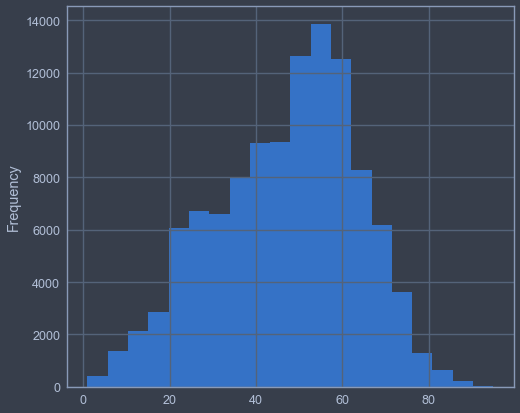

In [3]:
clean_data = data[data["Patient Age"] < 100]
print(f"""Mean age of patients: {clean_data["Patient Age"].mean()}""")
clean_data["Patient Age"].plot.hist(bins=20);

### Finding label
The `Finding Labels` column contains 1 to many possible labels that need to be split and encoded for each row. This might be easily done with sklearn [`One Hot Encoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) or may have to be performed imperatively:

In [4]:
label_set = set()
for labels in pd.unique(clean_data["Finding Labels"]):
    for label in labels.split("|"):
        label_set.add(label)

print("All labels:")
for i, label in enumerate(label_set):
    print(f"{i + 1}. {label}")
print(f"Total labels: {len(label_set)}")
    

All labels:
1. Pneumothorax
2. Infiltration
3. Consolidation
4. Pleural_Thickening
5. Emphysema
6. Hernia
7. Cardiomegaly
8. Edema
9. Mass
10. Nodule
11. Pneumonia
12. No Finding
13. Atelectasis
14. Effusion
15. Fibrosis
Total labels: 15


Consider that this will have to be done every time the data is loaded and it might be a good idea to generate a new CSV for future data use. There are other columns that can  potentially be dropped from the data as well, so this supports creating a "clean" CSV for further use.

### View Position
This column has 2 possible values, `PA` or `AP` and can be converted to a 0 or 1 value.

In [5]:
len(pd.unique(clean_data["View Position"]))

2

### Bad images
There are some images that are unusable for a variety of reasons. The [cxr14_bad_labels.csv](./dataset/cxr14_bad_labels.csv) contains a complete list of the images that cannot be used and the reasons for which they should be removed from the data.

In [6]:
bad_images = pd.read_csv("dataset/cxr14_bad_labels.csv").drop(["Index"], axis=1)
print(f"Total bad images: {len(bad_images)}")
bad_images.head(10)

Total bad images: 432


,File label,Inverted,Not frontal,Rotated
0,00000583_024.png,1.0,0.0,0.0
1,00002180_000.png,1.0,0.0,0.0
2,00002300_026.png,1.0,0.0,0.0
3,00002371_015.png,1.0,0.0,0.0
4,00006209_001.png,1.0,0.0,0.0
5,00007624_036.png,1.0,0.0,0.0
6,00008051_036.png,1.0,0.0,0.0
7,00009175_001.png,1.0,0.0,0.0
8,00009628_004.png,1.0,0.0,0.0
9,00010007_121.png,1.0,0.0,0.0


### Patient ID
There are several patients with multiple scans and these need to be taken into account when training the model. Additionally, with some patients that have multiple scans, there are different findings between each scan. This knowledge might be useful in training.

In [7]:
print(f"""Total number of patients: {len(pd.unique(clean_data["Patient ID"]))}""")

Total number of patients: 30802


### Follow-up ID
Not sure what this corresponds to and may not be a useful column. Will need to investigate further and determine its usefulness/meaning.

### Missing Data
Fortunately, there is no missing data in any of the columns, so no imputation or drops need to be done to account for this

In [8]:
clean_data.isna().sum()

Image Index       0
Finding Labels    0
Follow-up #       0
Patient ID        0
Patient Age       0
Patient Gender    0
View Position     0
Image Width       0
Image Height      0
Spacing X         0
Spacing Y         0
dtype: int64

### Gender
Might be better to relabel as "sex". The following is an example to get the count for a column, using this label.

In [9]:
clean_data["Patient Gender"].value_counts()

M    63328
F    48776
Name: Patient Gender, dtype: int64

## Use of data/model
The predictability model created by analyzing the data can be used to find the probability that a given scan is likely to have "No Finding" and get data back in real time without need for immediate human verification. IE if the model detects with a probability >85% that there is no finding, it can be de-prioritized in a queue of scans that need review. This would require a model that is trained to find a boolean of finding vs no finding.

Additionally, the data can be used for prioritizing particular findings that require further classification, more information, etc.

The `sklearn` library has a `predict_proba()` method that can be used to determine the probability that a specific prediction falls within a certain probability range.